# Spotify Clustering

## 1. Introduction

Spotify is one of the biggest platform to stream music on. An essential part of online platforms is the recommendation of products, in this case songs that fit the taste of the user. To recommend songs it is important to know the similarities and differences of songs. The big question is which tracks are similar, which are different and which would fit together? DJs or radio producer use their knowledge about music and musictaste to create matching playlists. Music streaming platforms need to do this automaticaly with their data about the songs and the users.

One step to achive this is the grouping of similar songs. When a user hears a song the app could recommend and create playlists with songs out of the same group.

With such a clustering of songs it would also be possible to extract the common or mean features of a group. This could also help music producers to create songs which sound familiar. Familiar songs are often liked more.

## 2. Dataset

The dataset I am using is "The Spotify Hit Predictor Dataset (1960-2019)" from Farooq Ansari. The data set is accessed through kaggle: https://www.kaggle.com/datasets/theoverman/the-spotify-hit-predictor-dataset/discussion/131250. The author states that the data is retrieved mostly through the Spotify API. Some features were generated through the API "call for Audio Analysis". The last feature was generated by the author himself.

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [2]:
# the data is differentiated in 6 files which are containing songs of a decade
# we add the decade to the dataframe so the information does not get lost
df1 = pd.read_csv("archive2\dataset-of-00s.csv")
df1["Decade"] = np.array([ 2000 for i in range(df1.shape[0])])
df2 = pd.read_csv("archive2\dataset-of-10s.csv")
df2["Decade"] = np.array([ 2010 for i in range(df2.shape[0])])
df3 = pd.read_csv("archive2\dataset-of-60s.csv")
df3["Decade"] = np.array([ 1960 for i in range(df3.shape[0])])
df4 = pd.read_csv("archive2\dataset-of-70s.csv")
df4["Decade"] = np.array([ 1970 for i in range(df4.shape[0])])
df5 = pd.read_csv("archive2\dataset-of-80s.csv")
df5["Decade"] = np.array([ 1980 for i in range(df5.shape[0])])
df6 = pd.read_csv("archive2\dataset-of-90s.csv")
df6["Decade"] = np.array([ 1990 for i in range(df6.shape[0])])
df = pd.concat([df1,df2,df3,df4,df5,df6],axis=0,ignore_index=True)

### 2.1 General inspectation of the dataset

In [3]:
df.shape # the dataset contains 41106 rows of datainstances and has 20 features

(41106, 20)

In [4]:
#checked some songs if the decade fits the releasedate of the songs with wikipedia
df.tail()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,Decade
41101,(You're A) Go Nowhere,Reagan Youth,spotify:track:4e86fqSFhqRQk3Z9hm7XHt,0.396,0.795,9,-6.070,0,0.2340,0.000928,0.000209,0.1820,0.762,152.943,82107,4,30.34109,6,0,1990
41102,La Fiebre de Norma,La Castañeda,spotify:track:43DFcnOZprnVlAFKwgBJ3e,0.621,0.655,9,-6.281,0,0.0309,0.050600,0.006260,0.0937,0.690,134.167,211653,4,34.89506,10,0,1990
41103,Good Times,Edie Brickell,spotify:track:6UPfnVoOq3y3BvapBIKs8J,0.562,0.314,10,-15.213,0,0.0298,0.440000,0.000011,0.1060,0.571,166.847,189827,4,21.11763,10,1,1990
41104,Inane,KMFDM,spotify:track:2Ao3Wi4raEOQfKQiU9EU8y,0.622,0.781,7,-6.080,1,0.0368,0.000101,0.755000,0.3830,0.214,120.051,330053,4,47.13558,11,0,1990
41105,You Can Make History (Young Again),Elton John,spotify:track:3ca91BX2k7GSzEUsx1mPgI,0.664,0.739,2,-9.005,1,0.0262,0.106000,0.054200,0.3330,0.458,92.257,293973,4,42.50341,14,1,1990


In [5]:
df.isna().sum().sum() #we have no Null values for this dataset, there is the possibility that this dataset already got filtered.

0

In [6]:
df.columns

Index(['track', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'target', 'Decade'],
      dtype='object')

Further information about the features can be accessed hereby: https://www.kaggle.com/datasets/theoverman/the-spotify-hit-predictor-dataset

- track: contains the songname
- artist: contains the name of the artist or band
- uri: resource identifier
- danceability: score from 0 to 1 describing how suitable a track is for dancing, computed through tempo, rhythm stability, beat strength, regularity
- energy: score from 0 to 1, describing how intensive and active a song is. Uses dynamic range, perceived loudness, timbre, onset rate, entropy
- key: 4 discrete values describing C, C?/D? and D
- loudness: overall loudness in dB
- mode: 2 discrete values describing Major and Minor mode
- speechiness: score from 0 to 1 describing presence of spoken words
- acousticness: score from 0 to 1 describing the confidence that the track is acoustic
- instrumentalness: score from 0 to 1 describing how little vocals are present
- liveness: describes the probability that audience was present during the recording
- valence: score from 0 to 1 describing musical positive valence
- tempo: estimation of Beats per minute
- duration_ms: duration of the song in milliseconds
- time_signature: number of beats in a bar (do not understand this feature because it does not correlate with tempo)
- chorus_hit: start of chorus (probably in seconds)
- sections: number of sections
- target: 2 discrete values describing if the song was featured in specific Playlists and Billboards

In [7]:
# We would like to see if some songs are duplicated
duplicated = df[df.duplicated(["track", "artist"])]
duplicated.head(3)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,Decade
719,Walking On A Dream,Empire of the Sun,spotify:track:6A6qBFJHid4WutQu6HHEZt,0.870,0.699,5,-5.541,0,0.0459,0.245000,0.000007,0.0588,0.7260,126.967,198440,4,31.29151,9,0,2000
831,Rock Formations,Yawning Man,spotify:track:0EAwKFwPX0JMI5QxuKxteG,0.496,0.656,11,-7.349,0,0.0384,0.001380,0.938000,0.0554,0.5040,115.504,321640,4,26.66693,12,0,2000
1647,Forgotten Scriptures,Disgorge,spotify:track:3p8KgeEYByP6F3xAp7ylKi,0.240,0.984,5,-8.998,1,0.1380,0.000204,0.877000,0.2020,0.0363,136.051,278853,4,65.05711,15,0,2000


In [8]:
duplicated.shape #1103 tracks are duplicates

(1103, 20)

In [9]:
#Example of duplicated songs. The uri is different but many features, like track,artist are the same
df.loc[df.track == "Walking On A Dream"]

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,Decade
671,Walking On A Dream,Empire of the Sun,spotify:track:0mBkoM8r7KAQzZij5swTUL,0.870,0.699,5,-5.541,0,0.0459,0.245,0.000007,0.0588,0.726,126.967,198440,4,31.29151,9,0,2000
719,Walking On A Dream,Empire of the Sun,spotify:track:6A6qBFJHid4WutQu6HHEZt,0.870,0.699,5,-5.541,0,0.0459,0.245,0.000007,0.0588,0.726,126.967,198440,4,31.29151,9,0,2000
10893,Walking On A Dream,Empire Of The Sun,spotify:track:5r5cp9IpziiIsR6b93vcnQ,0.871,0.701,5,-5.594,0,0.0458,0.257,0.000008,0.0589,0.716,126.975,198440,4,31.29041,9,1,2010


I would like to remove duplicate songs because they could skew our dataset. Songs which have the same combination of track and artist, should be dropped.

In [10]:
df["track_artist"] = df["artist"] + df["track"]
print(len(df.track_artist)) #now with the combination we have 41106 songs

41106


In [11]:
df = df.drop_duplicates("track_artist", keep= "first")
print(len(df.track_artist)) #after dropping duplicate tracks we have 40003 songs left

40003


In [12]:
df = df.set_index("track_artist")
df.head() # test if everything worked

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,Decade
track_artist,,,,,,,,,,,,,,,,,,,,
Montgomery GentryLucky Man,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.00000,0.159,0.532,133.061,196707,4,30.88059,13,1,2000
Pretty RickyOn The Hotline,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.00000,0.148,0.688,92.988,242587,4,41.51106,10,1,2000
CandlemassClouds Of Dementia,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.00457,0.174,0.300,86.964,338893,4,65.32887,13,0,2000
"ZwartketterijHeavy Metal, Raise Hell!","Heavy Metal, Raise Hell!",Zwartketterij,spotify:track:2IjBPp2vMeX7LggzRN3iSX,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.07840,0.192,0.333,148.440,255667,4,58.59528,9,0,2000
Billy CurringtonI Got A Feelin',I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.00000,0.125,0.631,112.098,193760,4,22.62384,10,1,2000


### 2.2 Cleaning Data 

In [13]:
rename_dict = dict(zip(df.columns,[i.lower() for i in df.columns] ))#store it as a dictionary
df.rename(columns=rename_dict, inplace = True)  #to use it in the rename function

We will drop some columns for the further analysis and clustering, because they are artificially generated and do not describe the nature of the songs, like the uri, which is an ID-code and the target, which specifies if the song is featured in specific playlists or billboards.

Humans could expect a certain style of music when they hear the name of the artist or the songname. But computer can not do this easily. Only because the name of two songs are the same it does not mean that they are similar sounding or fitting together. Also members of a band could change, without changing the bandname. And some bands write songs of different genres and style. Because of these reasons I would drop these two features, too.

I would also drop the decade, because I would like to generate groups independent of the release-year so newly released songs are not automatically skewed into groups of new songs. Also I would like to see how the groups change over the time, for this I do not want the clustering to be influenced by the decade. 

Some features (like time_signature) are a bit hard to understand or the difference between some features is not that clear. Nevertheless I will use them and assess later, if they are important and how it can be interpreted.

(array([8503., 7558., 6698., 5260., 5827., 6157.]),
 array([1960, 1970, 1980, 1990, 2000, 2010, 2020]),
 <BarContainer object of 6 artists>)

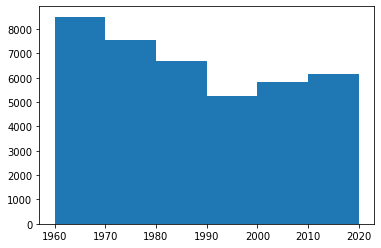

In [14]:
track = df["track"]         #we will drop some columns for the cluster analysis, so we store them in lists for later usage
artist = df["artist"]
uri = df["uri"]     
target = df["target"]     
decade = df["decade"]

df_clean = df.drop(["track","artist", "uri","target", "decade" ], axis=1)
plt.hist(decade, bins= range(1960,2030,10)) # with this histogram we see that every decades contains at least 5000 songs.

## 3. Transforming the dataset

### 3.1 Scaling

Because the features of the songs describe different things the range of the value can differ vastly. For example the danceability ranges from 0 to nearly 1. The loudness ranges from -49 to nearly 4. If we would use the number as they are now, the loudness would have a bigger impact on the similarity of two songs than the danceability. To prevent that we scale each variable to an equal level. For this we use the standartscaler which is not affected strongly by outliers. 

In [15]:
df_clean.describe() #these features are computable numbers

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections
count,40003.000000,40003.000000,40003.000000,40003.000000,40003.000000,40003.000000,40003.000000,40003.000000,40003.000000,40003.000000,40003.000000,4.000300e+04,40003.000000,40003.000000,40003.000000
mean,0.540064,0.579340,5.207884,-10.215422,0.693373,0.072973,0.364820,0.153990,0.201357,0.542844,119.341525,2.345338e+05,3.893733,40.120194,10.463865
std,0.177553,0.252223,3.534509,5.303226,0.461099,0.086316,0.338614,0.303261,0.172561,0.267202,29.106245,1.190447e+05,0.423347,19.019937,4.875651
min,0.000000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,1.516800e+04,0.000000,0.000000,0.000000
25%,0.421000,0.396000,2.000000,-12.810500,0.000000,0.033700,0.039800,0.000000,0.094100,0.330000,97.351500,1.727600e+05,4.000000,27.615080,8.000000
50%,0.552000,0.601000,5.000000,-9.250000,1.000000,0.043400,0.260000,0.000117,0.132000,0.559000,117.560000,2.176000e+05,4.000000,35.850210,10.000000
75%,0.669000,0.787000,8.000000,-6.373500,1.000000,0.069700,0.677000,0.059700,0.261000,0.768000,136.535500,2.662670e+05,4.000000,47.635400,12.000000
max,0.988000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.999000,0.996000,241.423000,4.170227e+06,5.000000,433.182000,169.000000


In [16]:
scaler = StandardScaler()
df_sc = scaler.fit_transform(df_clean.to_numpy())
df_sc = pd.DataFrame(df_sc, index=df_clean.index, columns=df_clean.columns)
df_sc.round(2).head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections
track_artist,,,,,,,,,,,,,,,
Montgomery GentryLucky Man,0.21,-0.43,-0.34,0.56,0.67,-0.51,0.01,-0.51,-0.25,-0.04,0.47,-0.32,0.25,-0.49,0.52
Pretty RickyOn The Hotline,0.92,1.09,1.36,0.89,-1.50,1.27,-1.02,-0.51,-0.31,0.54,-0.91,0.07,0.25,0.07,-0.10
CandlemassClouds Of Dementia,-2.13,1.02,1.07,1.36,0.67,-0.30,-1.08,-0.49,-0.16,-0.91,-1.11,0.88,0.25,1.33,0.52
"ZwartketterijHeavy Metal, Raise Hell!",-1.98,1.64,-0.34,1.22,0.67,1.08,-1.08,-0.25,-0.05,-0.79,1.00,0.18,0.25,0.97,-0.30
Billy CurringtonI Got A Feelin',0.51,0.73,-0.91,1.11,0.67,-0.53,-0.01,-0.51,-0.44,0.33,-0.25,-0.34,0.25,-0.92,-0.10


### 3.2 Covariance Analysis of the Features

In [17]:
df_sc.shape

(40003, 15)

Although we dropped some columns we still have 15 features. Data with 15 dimensions are hard to visualize. Also the more dimensions a dataset has, the more costly the computation gets. In addition differences of songs can get diluted by features which are always very similar i.e. speechiness with an standard deviation of 0.08. If some features correlate strongly with others, we could get rid of them without loosing much information. In the next step we check the covariance of the features.

In [18]:
df_sc.cov().round(2)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections
danceability,1.00,0.20,0.02,0.27,-0.03,0.16,-0.26,-0.30,-0.12,0.55,-0.07,-0.06,0.19,-0.04,-0.06
energy,0.20,1.00,0.02,0.77,-0.03,0.12,-0.71,-0.21,0.16,0.34,0.22,0.01,0.20,0.01,-0.04
key,0.02,0.02,1.00,0.01,-0.14,0.03,-0.02,-0.01,0.00,0.01,0.00,0.01,0.01,0.01,0.01
loudness,0.27,0.77,0.01,1.00,0.00,0.07,-0.56,-0.38,0.09,0.27,0.17,-0.05,0.16,-0.01,-0.08
mode,-0.03,-0.03,-0.14,0.00,1.00,-0.06,0.05,-0.08,0.01,0.04,0.03,-0.07,-0.01,-0.02,-0.06
speechiness,0.16,0.12,0.03,0.07,-0.06,1.00,-0.08,-0.08,0.13,0.00,0.04,0.01,0.02,0.01,-0.01
acousticness,-0.26,-0.71,-0.02,-0.56,0.05,-0.08,1.00,0.21,-0.03,-0.19,-0.18,-0.07,-0.19,-0.01,-0.02
instrumentalness,-0.30,-0.21,-0.01,-0.38,-0.08,-0.08,0.21,1.00,-0.05,-0.29,-0.05,0.11,-0.08,0.05,0.08
liveness,-0.12,0.16,0.00,0.09,0.01,0.13,-0.03,-0.05,1.00,-0.00,0.02,0.01,0.00,0.04,-0.01
valence,0.55,0.34,0.01,0.27,0.04,0.00,-0.19,-0.29,-0.00,1.00,0.11,-0.17,0.15,-0.06,-0.13


We see that some feature covary strongly with each other. For example loudness and energy with 0.77. There is the possibility that spotify uses the loudness among other things to calculate the energy score. On the other hand some features do not covariate strongly with any feature, for example the key of the song. By looking at this table we can better understand the features and how they are related to each other. For example high instrumentalness seem to hurt the danceability, whereas positive valence supports danceability.

### 3.3 Principal Component Analysis

Because most of the features are correlated, it makes sense to group them in so called principal components. The first principal component explains most of the variance of the songs, the last component the least. When analyzing the sompnents of the pca, information which feature descriminates the songs the strongest can be gathered.

In [19]:
pca=PCA(random_state=1)
pca_transformed=pca.fit_transform(df_sc)
df_pca=pd.DataFrame(pca_transformed, index=df.index)
df_pca.round(2).head() #these are the new features calle principal components

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
track_artist,,,,,,,,,,,,,,,
Montgomery GentryLucky Man,-0.28,-0.04,0.36,-1.15,-0.11,-0.25,0.02,-0.24,0.09,0.20,-0.46,0.11,-0.47,-0.46,-0.44
Pretty RickyOn The Hotline,-2.05,0.45,0.58,2.31,-0.29,-0.20,0.04,0.17,-0.71,0.56,0.14,-0.23,0.25,0.05,0.01
CandlemassClouds Of Dementia,-0.45,1.57,-1.64,0.26,-0.32,1.64,0.77,-1.34,-0.58,1.68,-0.34,-0.88,0.79,-0.40,-0.00
"ZwartketterijHeavy Metal, Raise Hell!",-1.27,0.79,-2.70,-0.44,0.18,0.59,0.06,0.66,0.40,1.30,-0.51,-0.82,0.68,0.06,0.14
Billy CurringtonI Got A Feelin',-1.25,-0.41,0.47,-1.38,-0.07,0.07,-0.33,-0.09,-0.85,0.18,-0.03,-0.48,-0.48,0.15,-0.08


In [20]:
df_pca.cov().round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,3.08,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00
1,0.00,1.96,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00
2,-0.00,-0.00,1.35,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00
3,-0.00,-0.00,0.00,1.18,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00
4,-0.00,-0.00,0.00,0.00,1.09,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00
5,-0.00,0.00,-0.00,0.00,-0.00,1.05,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00
6,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.93,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00
7,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.91,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00
8,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.87,-0.00,0.00,-0.00,0.00,0.00,0.00
9,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.82,-0.00,0.00,-0.00,-0.00,0.00


Now we have computed features which are not correlated to each other anymore. Also we see that some features describe a lot of variance and some less - the first feature the most and the last the least.

With this information we can decide how many features/dimensions are necessary to maintain a good amount of information and how many Principal components can be dropped.

[0.20537766 0.1305972  0.09011751 0.07884346 0.07240674 0.06970425
 0.06200789 0.06061968 0.05799392 0.05471055 0.04890597 0.0288503
 0.02459645 0.00937964 0.00588879]
[0.20537765972563055, 0.33597486053126374, 0.4260923706162977, 0.5049358261275337, 0.5773425644845672, 0.6470468174127322, 0.7090547046770065, 0.7696743896256797, 0.8276683072874462, 0.8823788569815362, 0.9312848244515266, 0.9601351241705742, 0.9847315756584811, 0.9941112111247514]


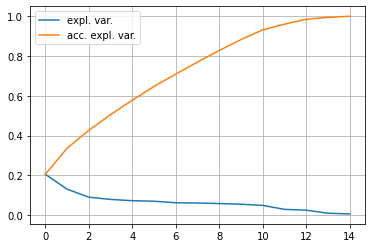

In [21]:
expl_var=pca.explained_variance_ratio_
print(expl_var)

print([sum(expl_var[0:i]) for i in range(1,len(expl_var))])

plt.figure()
plt.grid()
plt.plot(expl_var, label='expl. var.')
plt.plot(np.add.accumulate(expl_var), label='acc. expl. var.')
plt.legend()
plt.show()

- The first 2 principal components account for over 33% of the variance.
- The first 9 principal components account for more than 80% of the variance.

From here on we use just the first 9 principal components, which still accounts for more than 80% of the variance. With this step we are able to reduce one third of the dimensions. 

In [22]:
from pca import pca
model = pca(n_components=9)

# Fit transform
results = model.fit_transform(df_sc)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [15] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[9]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


[pca] >Plot PC1 vs PC2 with loadings.


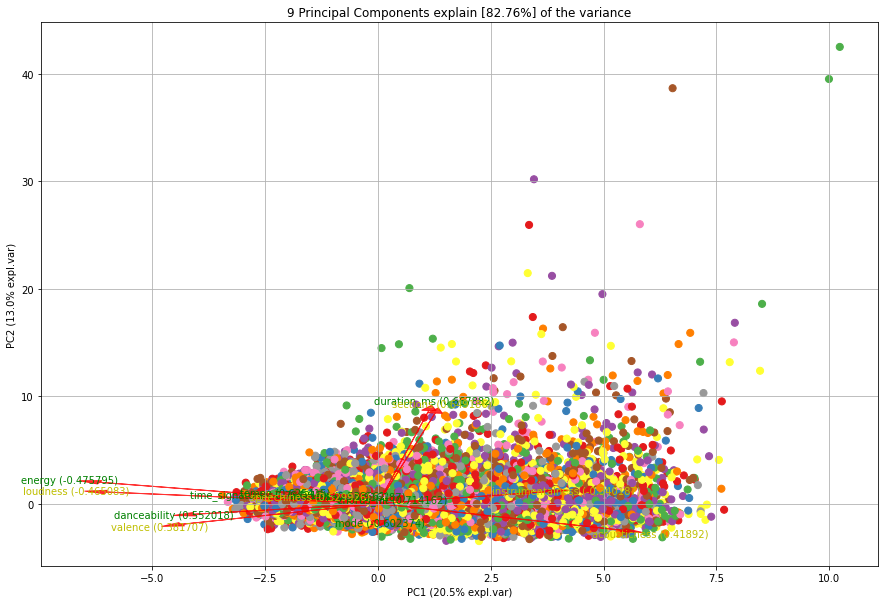

In [23]:
# biplot with number of original features (plot data and loadings)
# for this figure we use the first and the second principal component.
fig, ax = model.biplot(n_feat=15, legend=False, label=None)

We see our datapoints spreaded in the two most important dimensions which explain 20.5% and 13.02% of the variance. The depiction skewed because of the outliers in the top right corner.

[pca] >Plot PC1 vs PC2 with loadings.


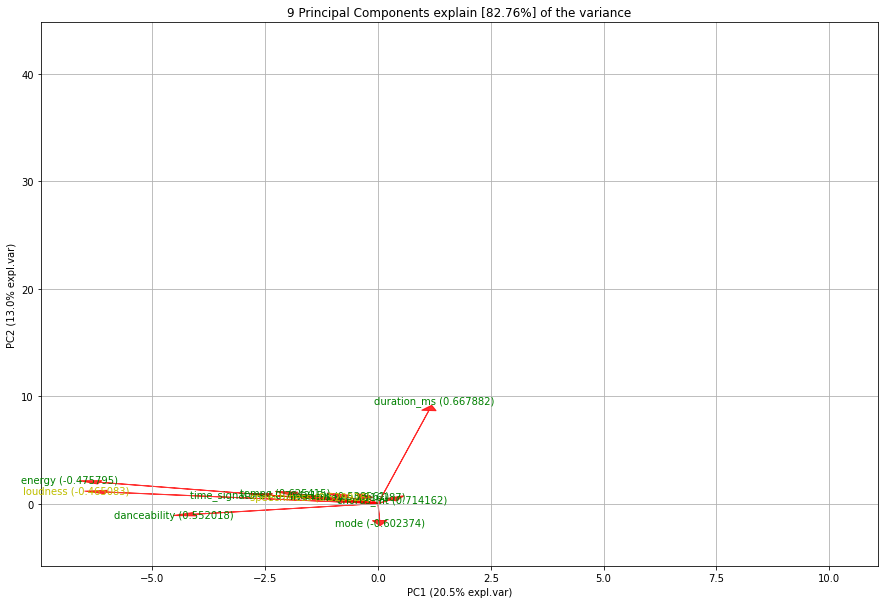

In [24]:
# biplot without points to see the loadings better
fig, ax = model.biplot(cmap= None, n_feat=11, legend=False, label=None, alpha_transparency=0.0001)

In this depiction we can see how the original features are influencing the first two principal components. All of them play a part, but some have a strong influence like duration_ms or energy. Features which are close together like energy and loudness are strongly correlated as we have seen already in the covariance analysis. Danceability and time_signal also seem to correlate slightly with them. Features which are orthogonal to each other are independent.

## 4. Clustering of data

### 4.1 KMeans

After we analyzed and cleaned and transformed our data, we will cluster the dataset in different groups. First we use KMeans, an approach which takes the mean distances of points to its medoid. To use Kmeans we need to decide in how many groups the data should get divided. To help us with this decisions we use two different methods. 

In [25]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
from kneed import  KneeLocator

### 4.2 KMeans functions

In [26]:
def silhou_inertia_func(data, k_start: int, k_end: int):
    '''
        this function computes the silhouette coefficients of a KMeans clustering for different k (numbers of cluster within a clustering).

        input:
            data (np.array): dataset which should get analyzed
            k_start (int): start of the range of k which should be computed
            k_end (int):(included) end of the range of k which should be computed 
        
        output:
            silhouettes (list): gives back a list of silhouette values for the requested k
            inertia (list): gives back a list of inertia values for the requested k
    '''

    silhouettes=[]
    inertia = []

    for k in range(k_start,k_end+1):
        #we fix the randomstate to 1 to ensure reproducability
        kmeans=KMeans(n_clusters=k, random_state=1) 
        cluster_assignments = kmeans.fit_predict(data) 
        silhouettes.append(silhouette_score(data,cluster_assignments))
        inertia.append(kmeans.inertia_)

    return silhouettes, inertia



In [27]:
#this function is a general way to plot lines

def line_plot(k_list, list_values, linestyle = "-"): 
    '''
        This function plots a line for given y and x values.

        input:
            k_list (list, tupel or range): iterable object of the ks which were used for the silhouette coefficients
            list_values (np.array): array of the computed silhouette coefficients
            linestyle (str): describes how the line connecting the points lokks like
        
        output: 
            Line plot diagram 
    '''

    plt.plot(k_list,list_values, linestyle= linestyle)


### 4.3 Silhouette Coefficient

One way to get an idea which number of groups (k) we use is the Silhouette coefficient. It contains the distances between a member of a group with its members of the same group and compares them to the distance to members of another group. The bigger the difference of this scores are the better is the structure of the clustering.

In [28]:
#store the values in two variables and use k=2,...10
silhouettes_list, inertia_list = silhou_inertia_func(df_pca,2,10)

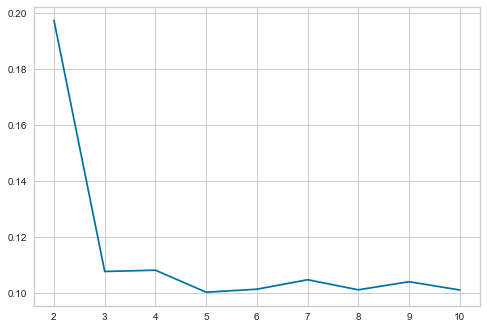

In [29]:
line_plot(range(2,11), silhouettes_list)

The silhouette Coefficient shows relatively low scores between 0.1 and 0.2 for every k from 2 to 10. A rule of thumb says that scores above 0.7 indicate strong structures. 

We see that every silhouette for every k is not very good (above 0.7). A score below 0.5 is seen as a very bad structure.
The strongest score with nearly 0.2 is k=2. This indicates the best clustering would be with 2 groups.

We should keep in mind that we want to group the songs in the dataset into groups with similar features. When we would like to have more granular groups we could decide to use a higher k.

### 4.4 Elbow method

An alternative method uses the cost function of kmeans and plots it for a range of ks. Because of the construction of the cost functions the inertia decreases with increasing k. At some point the inertia does not decrease as fast as before, and the increasing k is less efficient. We find this point by using the elbow method. It takes the point where the curvature is strongest. 

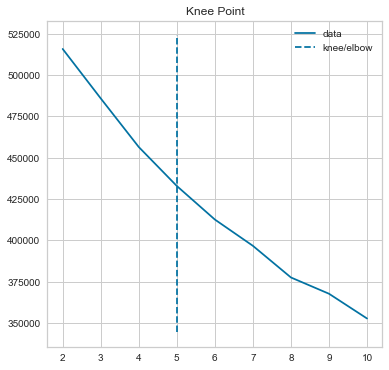

In [30]:
x = np.array([i for i in range(2,11)])
y = np.array(inertia_list)
#use decreasing and convex to fit it to the inertia line.
kl = KneeLocator(x,y, curve= "convex", direction = "decreasing", S=1, online= True)
kl.plot_knee()

We see that there is only a slight curvature. This function shows the biggest change at k=5, but we have to admit that this is not a strong argument, because the overall curvature is so slightly.

Eventhough both k are not good, we would like to see how the dataset would be devided.

### Visualization Functions

In [31]:
def show_clustering(X, kmeans, cluster_assignments, color_list):
    '''
        This function shows the assigned clusters with their centroids in a scatterplot and the Silhouette Scores of each data instance.

        input:
            X (np.array) : dataset which should be displayed
            kmeans (function) : kmeans function which was computed on the dataset
            cluster_assignment (np.array(list)) : computed cluster assignments for each datainstance
            color_list (list) : list of colors which should be used. Must be long enough

        output: 
            returns a color-coded Scatterplot of the assigned clusters and a Silhouette Plot of all data instances.
    '''
    plt.figure(figsize=(8, 8))

    for i in range(0,len(np.unique(cluster_assignments))):
        X_sub = X[cluster_assignments==i, :]
        plt.scatter(X_sub[:, 0], X_sub[:, 1], c=color_list[i], label=i, alpha=0.3)
    
    plt.scatter(
        kmeans.cluster_centers_[:, 0], 
        kmeans.cluster_centers_[:, 1],
        s=350, marker='*', c='crimson', edgecolor='black'
    )

    plt.legend()
    plt.show()

    visualizer = SilhouetteVisualizer(kmeans, colors=color_list, is_fitted=True)

    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.finalize()
    visualizer.show()

In [32]:
def kmeans_clustering(data_set, k):
    '''
        Clusters a dataset with a fixed number of clusters k.

        input: 
            dataset (np.array): dataset which gets analyzed
            k (int): number of clusters/groups into which the dataset gets divided
        
        output: 
            returns a np.array with the assignements to the clusters
            returns the cluster
    '''

    cluster = KMeans(n_clusters= k, random_state=1)
    cluster_assignments = cluster.fit_predict(data_set)
    return cluster_assignments, cluster

### 4.5.1 Kmeans clustering k=2

In [33]:
array_pca = np.array(df_pca)
cluster_assignment_k2, clusterk2 = kmeans_clustering(array_pca,2)

(array([28573., 11430.]),
 array([0. , 0.5, 1. ]),
 <BarContainer object of 2 artists>)

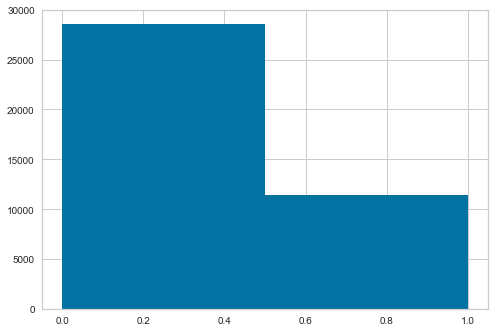

In [34]:
plt.hist(cluster_assignment_k2,bins=2 , align="mid")

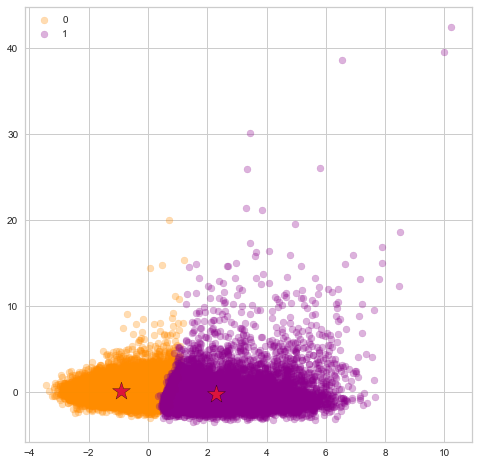

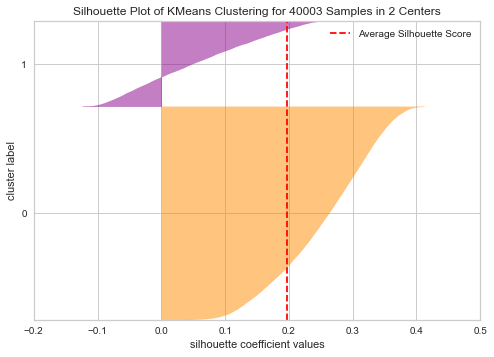

In [35]:
colors=['darkorange', 'darkmagenta', 'blue', 'k', 'green']
show_clustering(array_pca, clusterk2, cluster_assignment_k2, colors)

The kmeans clustering with k=2 splits the dataset along the first principal component. Cluster 0 contains more songs than cluster 1. Cluster 1 has some negative silhouette values. 

### 4.5.2 Kmeans clustering k=5

(array([14818.,  8757.,  8313.,  7297.,   818.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

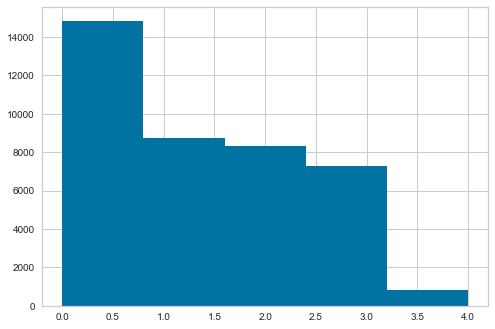

In [36]:
cluster_assignment_k5, clusterk5 = kmeans_clustering(array_pca,5)
plt.hist(cluster_assignment_k5,bins=5 , align="mid")

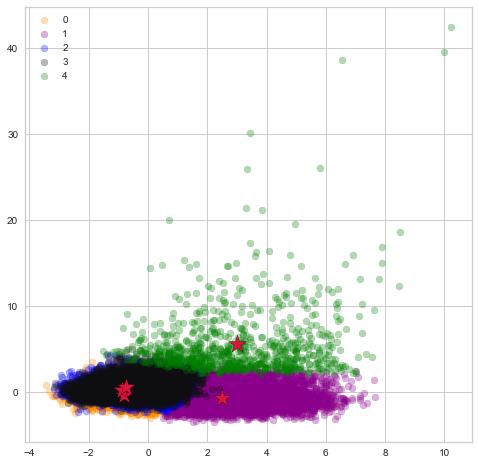

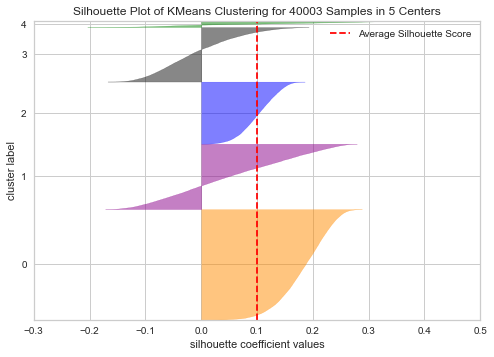

In [37]:
# es muss noch geschaut werden welche Dimensionen gezeigt werden

colors=['darkorange', 'darkmagenta', 'blue', 'k', 'green']
show_clustering(array_pca, clusterk5, cluster_assignment_k5, colors)

With k=5 clusters the average silhouette score is only half as good as with  k=1. Three clusters have many negative values, showing that it is hard to produce kmeans cluster with good structrure. Negative values indicate that some points are closer to the members of another cluster than the members of their own cluster. These points could be located at the edge of its cluster and near the the next cluster.

The kmeans with k=2 was better,  but with just two groups this clustering can not help us to find similar songs that may fit to the taste of a user.

To circumvent the problems with points being closer to points of other clusters, we can use methods that can label points not fitting to either cluster as noise. With such a method, the groups we get are more similar within each other, but with the drawback that some songs are not assigned to any group.

### 4.6 Density Based Clustering

A method which can handle noise is density based clustering. It looks for each point how many neighbors are in a given radius of it. If a point overcomes a threshold of number of near neighbors it is seen as a core part of a cluster.

To use the method DBSCAN we need to decide on two factors: 1. How big is the radius in which we count the neighboring points? 2. How many points need to be in this radius?

To decide on the number of neighbors we use the heuristic MinPts = k+1. A heuristic to choose k, is to set k to 2 ∗ dimensions -1 (Sander, Ester et al., 1998). Because we have 9 dimensions this would mean MinPts= 18. 

To decide on the radius we need to try some values and observe how the number of clusters change and how many points get classified as noise. We need to gauge these aspects and decide on that.

### 4.6.1 DBscan with eps=1.5 and min_samples 18

In [40]:
dbscan=DBSCAN(eps=1.5, min_samples=18, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=3)
dbscan_clusters=dbscan.fit_predict(df_pca)
print(np.unique(dbscan_clusters)) # -1 is the marker for noise instances

[-1  0  1  2  3  4  5]


With eps 1.5 we have 6 clusters plus noise. The number of clusters would be useful to group similar songs.

(array([17206., 16617.,  5441.,   656.,    48.,    35.]),
 array([-1,  0,  1,  2,  3,  4,  5]),
 <BarContainer object of 6 artists>)

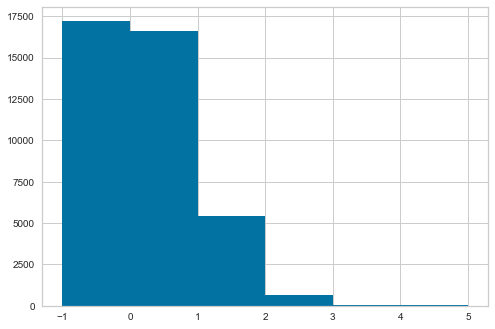

In [41]:
plt.hist(dbscan_clusters, bins=range(-1,6), align="mid")

But as we see in the histogram the biggest group is the noise group. With this epsilon we could not assign over a third of the songs to a group. Lets try a higher Epsilon.

### 4.6.2 DBscan with Eps=2.5 and minpts=18

In [42]:
dbscan=DBSCAN(eps=2.5, min_samples=18, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=3)
dbscan_clusters=dbscan.fit_predict(df_pca)
print(np.unique(dbscan_clusters)) # -1 is the marker for noise instances

[-1  0  1]


With a higher epsilon we do not have as much noise. But nearly all songs are part of cluster 0. With this we have no usable information about the songs and their similarity.

(array([ 2208., 37681.,   114.]),
 array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 <BarContainer object of 3 artists>)

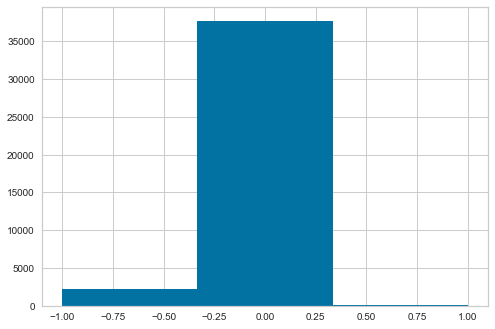

In [43]:
plt.hist(dbscan_clusters, bins=3, align="mid")

### 4.6.3 Dbscan with eps=2 and minpts= 18

In [44]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps=2, min_samples=18, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=3)
dbscan_clusters=dbscan.fit_predict(df_pca)
print(np.unique(dbscan_clusters)) # -1 is the marker for noise instances

[-1  0  1  2  3  4  5]


(array([5.8350e+03, 2.2618e+04, 9.3140e+03, 1.8510e+03, 2.9800e+02,
        7.5000e+01, 1.2000e+01, 0.0000e+00, 0.0000e+00]),
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]),
 <BarContainer object of 9 artists>)

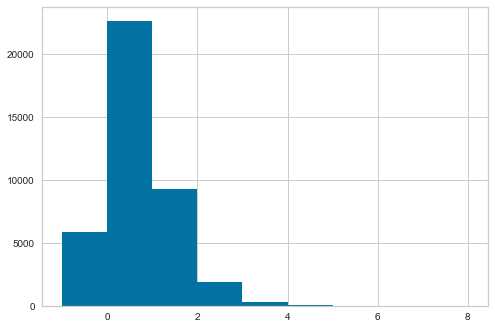

In [45]:
plt.hist(dbscan_clusters, bins=range(-1,9), align="mid")

Now we have as many clusters as with eps=1.5 but we have much less noise. With this eps=2.0 we achieved a good middleground.

For another way to understand the influence of epsilon we can use the next visualization.

### 4.7 Visualization of different Epsilon with optics

In [46]:
## Optics
from sklearn.cluster import OPTICS
array_pca = np.array(df_pca)

In [47]:
optics = OPTICS(min_samples=18, xi=2, min_cluster_size=0.05)
optics.fit(array_pca)
labels_xi=optics.labels_

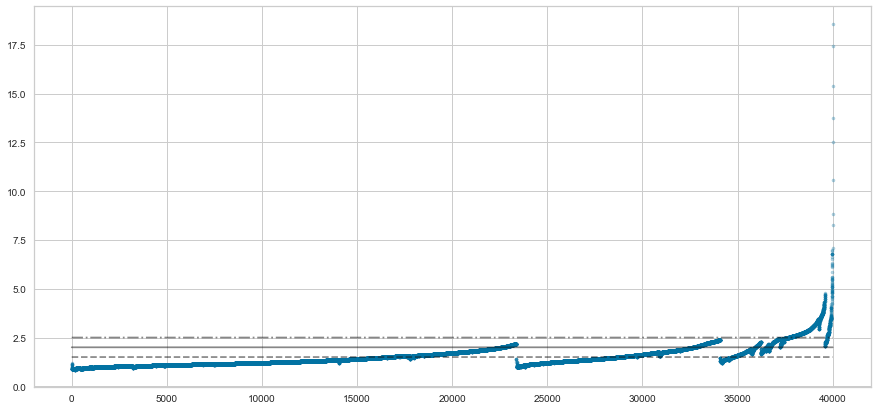

In [48]:
space = np.arange(len(array_pca))
reachability = optics.reachability_[optics.ordering_]
plt.figure(figsize=(15, 7))
plt.scatter(space, reachability, alpha=0.3, s=10)
#We plot three lines indicating the different eps
plt.plot(space, np.full_like(space, 2.5, dtype=float), "k-.", alpha=0.5)
plt.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
plt.plot(space, np.full_like(space, 1.5, dtype=float), "k--",alpha=0.5)

The lowest line (eps=1.5) considers points above the line as noise. The higher lines label less points as noise. 
The highest line (eps=2.5) divides the data in just two groups. Whereas the line with eps=2.0 divides the data visibly in more than three groups. With epsilon we can dictate how dense points must be that they are considered as clusters.

### 4.8 Visualization of DBscan

After we decided on the epsilon we will visualize the clusters.

In [49]:
colors=['darkorange', 'darkmagenta', 'dodgerblue', 'lightgreen', 'yellow', 'grey', 'green', 'red']

In [50]:
def plot_clusters(X, clusters,ax0,ax1,noise):
    for cluster in np.unique(clusters):
        if (cluster!=-1):
            X_cluster=X[clusters==cluster, :]
            plt.scatter(X_cluster[:,ax0], X_cluster[:,ax1], c=colors[cluster], alpha=0.2)
    X_noise=X[clusters==-1, :]
    if noise:
        plt.scatter(X_noise[:,ax0], X_noise[:,ax1], c='black', alpha=0.1)

First we have a look on the two most important pca

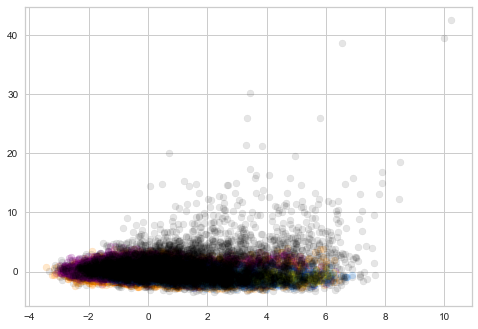

In [51]:
plot_clusters(np.array(df_pca),dbscan_clusters,0,1,True)

Because of the noise the points are displayed very condensed and skewed.
By not showing the noise we circumvent this problem.

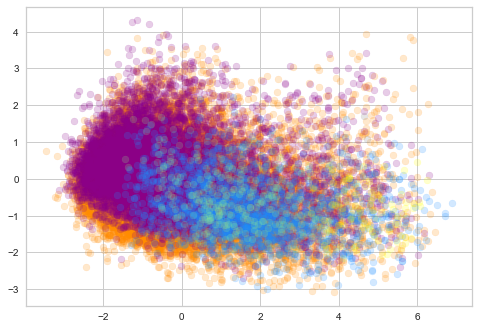

In [52]:
plot_clusters(np.array(df_pca),dbscan_clusters,0,1,False)

Next we display the songs onto the 3rd and 4th principal component.

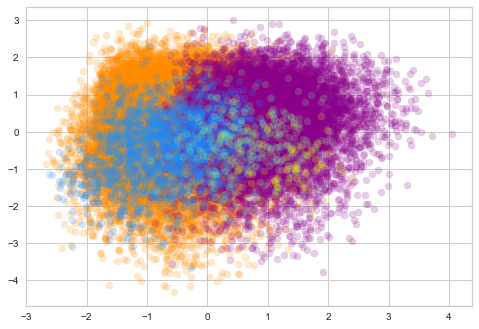

In [53]:
plot_clusters(np.array(df_pca),dbscan_clusters,3,2,False)

Because we can only see two dimensions at once the clusters are on top of each other and overlap strongly. Nevertheless we see that the points within a cluster are clumped together. In this plot we also see the different sizes of the clusters again.

As we can see cluster 0 (orange) and cluster 1 (magenta) are nearly exactly on top of each other in the first depiction with the first two principal components. But in the next depiction they are seperated more strongly, because other dimensions are shown.

In the depiction with noise we saw, that most points are realtively close together, but there are outliers which are detected as noise.

## 5. Control/Assessment

In [54]:
df["assignment"]= dbscan_clusters
df.loc[df["assignment"]==3].head(5)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,assignment
track_artist,,,,,,,,,,,,,,,,,,,,,
Stone Metal Fireคนไร้ค่า,คนไร้ค่า,Stone Metal Fire,spotify:track:0K1U7QPsuA6tU0gJTvHZpC,0.473,0.4640,10,-8.112,0,0.0287,0.00267,...,0.1070,0.2500,128.955,272400,3,47.53233,12,0,2000,3
John RutterThe Sprig of Thyme: No. 1. The bold grenadier,The Sprig of Thyme: No. 1. The bold grenadier,John Rutter,spotify:track:0qrluoRkYlnM7R46lJs6Gr,0.190,0.0237,5,-29.269,0,0.0397,0.99100,...,0.1040,0.1400,103.604,182400,3,20.01717,10,0,2000,3
Choir of the Monks of ChevetogneUnder Thy Protection (Pod Tvoju Milost),Under Thy Protection (Pod Tvoju Milost),Choir of the Monks of Chevetogne,spotify:track:3peL9cqmPNF73Wn8faWHMy,0.119,0.1490,10,-18.057,0,0.0380,0.98900,...,0.1400,0.0371,71.794,180333,3,36.81891,11,0,2000,3
Smokie NorfulI Need You Now,I Need You Now,Smokie Norful,spotify:track:44q2DhInsQYJ8X1q2H1RNj,0.339,0.2730,5,-9.945,0,0.0309,0.72900,...,0.1520,0.3040,96.804,251467,3,74.40480,8,1,2000,3
Benjamin BrittenFolk Song Arrangements: Greensleves,Folk Song Arrangements: Greensleves,Benjamin Britten,spotify:track:4yASD64X2S2kIesfFVSdz3,0.380,0.0249,7,-24.296,0,0.0789,0.98500,...,0.0728,0.1390,121.594,137667,3,58.96868,5,0,2000,3


In [55]:
df.loc[df["assignment"]==2].head(5)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,assignment
track_artist,,,,,,,,,,,,,,,,,,,,,
Say AnythingI Want to Know Your Plans,I Want to Know Your Plans,Say Anything,spotify:track:3pjnCLIHbRczUjenWOEo56,0.647,0.324,7,-9.679,1,0.0377,0.354,...,0.1150,0.344,124.213,314286,3,32.66343,16,0,2000,2
Tito SchipaEra De Maggio,Era De Maggio,Tito Schipa,spotify:track:1YJ7qQEFIkh2r8VEb5X8lp,0.395,0.248,1,-10.025,1,0.0519,0.979,...,0.1770,0.324,85.174,207888,3,34.50252,10,0,2000,2
John LegendOrdinary People,Ordinary People,John Legend,spotify:track:2ZA4uMlSZjaoWGFqP1tsLI,0.469,0.132,10,-14.001,1,0.0807,0.929,...,0.0873,0.360,67.011,281467,3,23.73524,11,1,2000,2
RadioheadNude,Nude,Radiohead,spotify:track:5k7VKj1Xwy5DjO4B0PdAOb,0.537,0.342,4,-9.785,1,0.0338,0.833,...,0.0856,0.156,128.331,255387,3,40.58623,10,1,2000,2
Janet JacksonI Want You,I Want You,Janet Jackson,spotify:track:5xDDEqO786YBj3tJDSR2Ms,0.643,0.843,3,-5.533,1,0.0384,0.172,...,0.1220,0.666,105.744,252800,3,50.25079,9,1,2000,2


In [56]:
df.loc[df["assignment"]==1].head(5)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,assignment
track_artist,,,,,,,,,,,,,,,,,,,,,
Pretty RickyOn The Hotline,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.0185,...,0.1480,0.688,92.988,242587,4,41.51106,10,1,2000,1
State Of ArtDantzig Station,Dantzig Station,State Of Art,spotify:track:5Z3nrC0JbJmXaOGiXTuNFk,0.726,0.837,11,-7.223,0,0.0965,0.3730,...,0.1360,0.969,135.347,192720,4,28.29051,10,0,2000,1
Alan JacksonWhere I Come From,Where I Come From,Alan Jackson,spotify:track:6ej1QJ8eIYmhsyTlvgDajy,0.726,0.631,11,-8.136,0,0.0334,0.2200,...,0.1930,0.746,124.711,239240,4,35.59732,10,1,2000,1
Big Punisher Featuring Donell JonesIt's So Hard,It's So Hard,Big Punisher Featuring Donell Jones,spotify:track:5NQdweL8O7nGdM7e4IS1lf,0.900,0.593,10,-6.629,0,0.3330,0.0554,...,0.0304,0.633,92.946,172933,4,21.78144,9,1,2000,1
Fat Joe Featuring Lil WayneMake It Rain,Make It Rain,Fat Joe Featuring Lil Wayne,spotify:track:1Ji8DhJGIQuV9kBiTgcChh,0.744,0.697,11,-5.063,0,0.1970,0.0106,...,0.0842,0.767,149.280,247413,4,42.63475,9,1,2000,1


- the 1st Cluster contains tracks with Rnb, New Wave, Hip Hop
- the 2nd Cluster contains tracks with Rock, Opera, Pop,  
- The 3rd Cluster contains tracks with Rock, Classical music and Gospel music.

This list is not complete at all and is just a mere glimpse in our groups, but the few songs we looked at did not seem irrationally assigned to each other. Eventhough no human would group songs like this, with the usage of so many features, but the computed clustering could still help to find music which fits to another song.

## 6. Interpretation/ Usecase

Because the interpretation of principal components are difficult, we display the two original dimensions. We choose the features energy and duration because they were important in the first two principal components. Also we use the information in which decade the songs where released to display them seperately. 

In [57]:
df_time = df
df_time["assignment"]= dbscan_clusters
df_time ["decade"] = decade

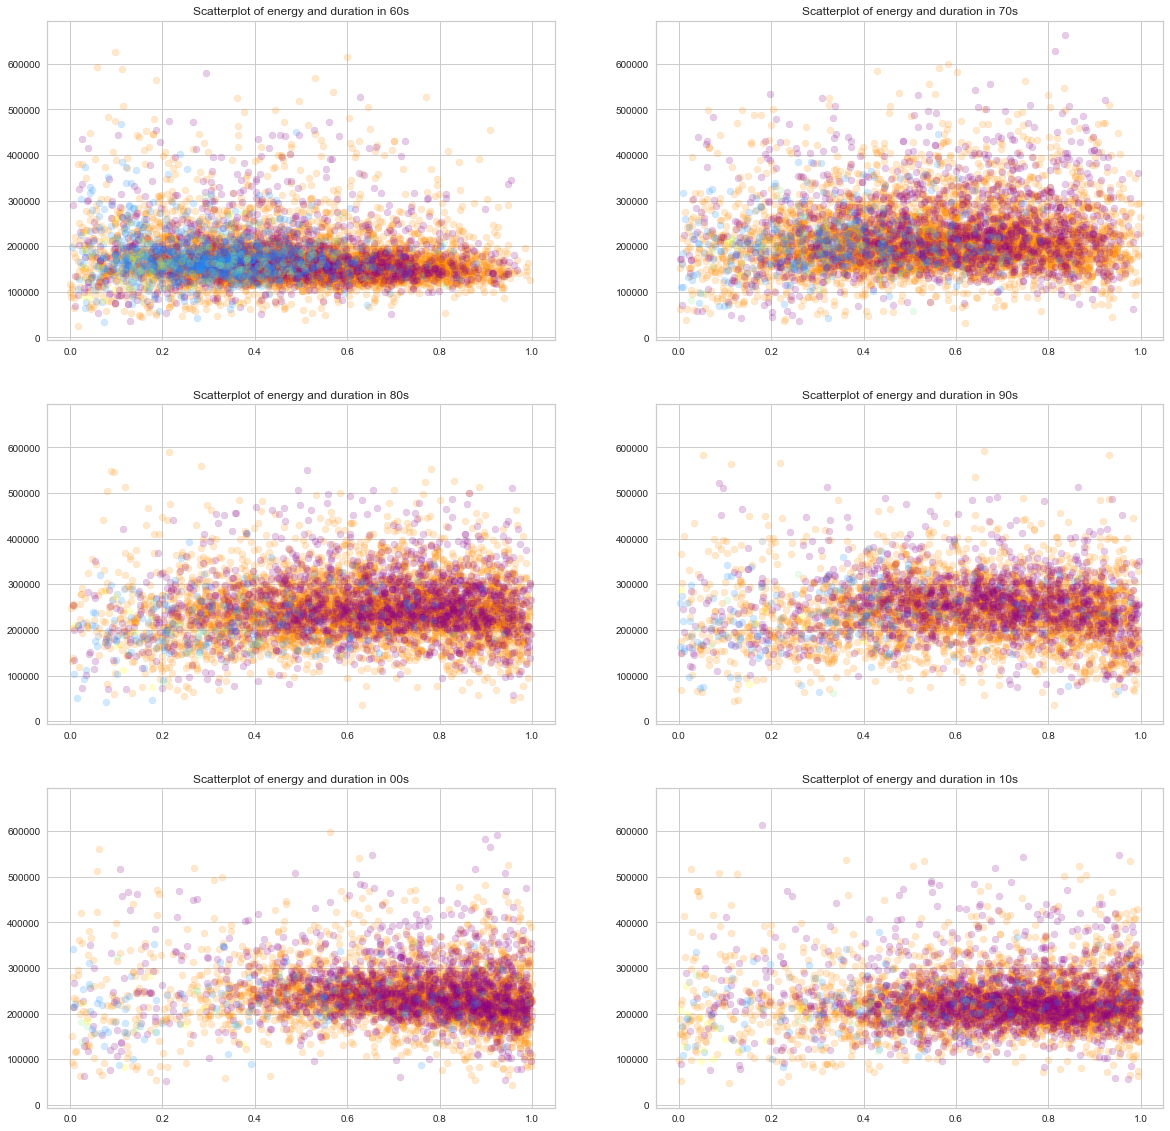

In [58]:
plt.figure(figsize=(20,20))
ax1= plt.subplot(3,2,1)
plt.title('Scatterplot of energy and duration in 60s')
plot_clusters(np.array(df_time[df_time.decade==1960]),dbscan_clusters[df_time.decade==1960],4,14,False)
plt.subplot(3,2,2, sharex= ax1, sharey=ax1)
plt.title('Scatterplot of energy and duration in 70s')
plot_clusters(np.array(df_time[df_time.decade==1970]),dbscan_clusters[df_time.decade==1970],4,14,False)
plt.subplot(3,2,3, sharex= ax1, sharey=ax1)
plt.title('Scatterplot of energy and duration in 80s')
plot_clusters(np.array(df_time[df_time.decade==1980]),dbscan_clusters[df_time.decade==1980],4,14,False)
plt.subplot(3,2,4, sharex= ax1, sharey=ax1)
plt.title('Scatterplot of energy and duration in 90s')
plot_clusters(np.array(df_time[df_time.decade==1990]),dbscan_clusters[df_time.decade==1990],4,14,False)
plt.subplot(3,2,5, sharex= ax1, sharey=ax1)
plt.title('Scatterplot of energy and duration in 00s')
plot_clusters(np.array(df_time[df_time.decade==2000]),dbscan_clusters[df_time.decade==2000],4,14,False)
plt.subplot(3,2,6, sharex= ax1, sharey=ax1)
plt.title('Scatterplot of energy and duration in 10s')
plot_clusters(np.array(df_time[df_time.decade==2010]),dbscan_clusters[df_time.decade==2010],4,14,False)
plt.show()



We see that the blue and green clusters (maybe yellow too) are predominantely in the 60s dataset, although the decade was not part of the featuring. It seems that some clusters have features which are often in older songs. The magenta cluster is more dominant in the 00s and 10s. We also see that the energy scores are shifiting higher for most clusters. This could indicate that the taste of producers and consumers changed in regard to energetic music. There is not a clear trend for the length of the songs the spread of the points indicate maybe a lower variance of the songlength. This should be checked with statistical methods. 

Again we see that these two components are independent of each other. 

Next we look at two further dimensions energy and acousticness.

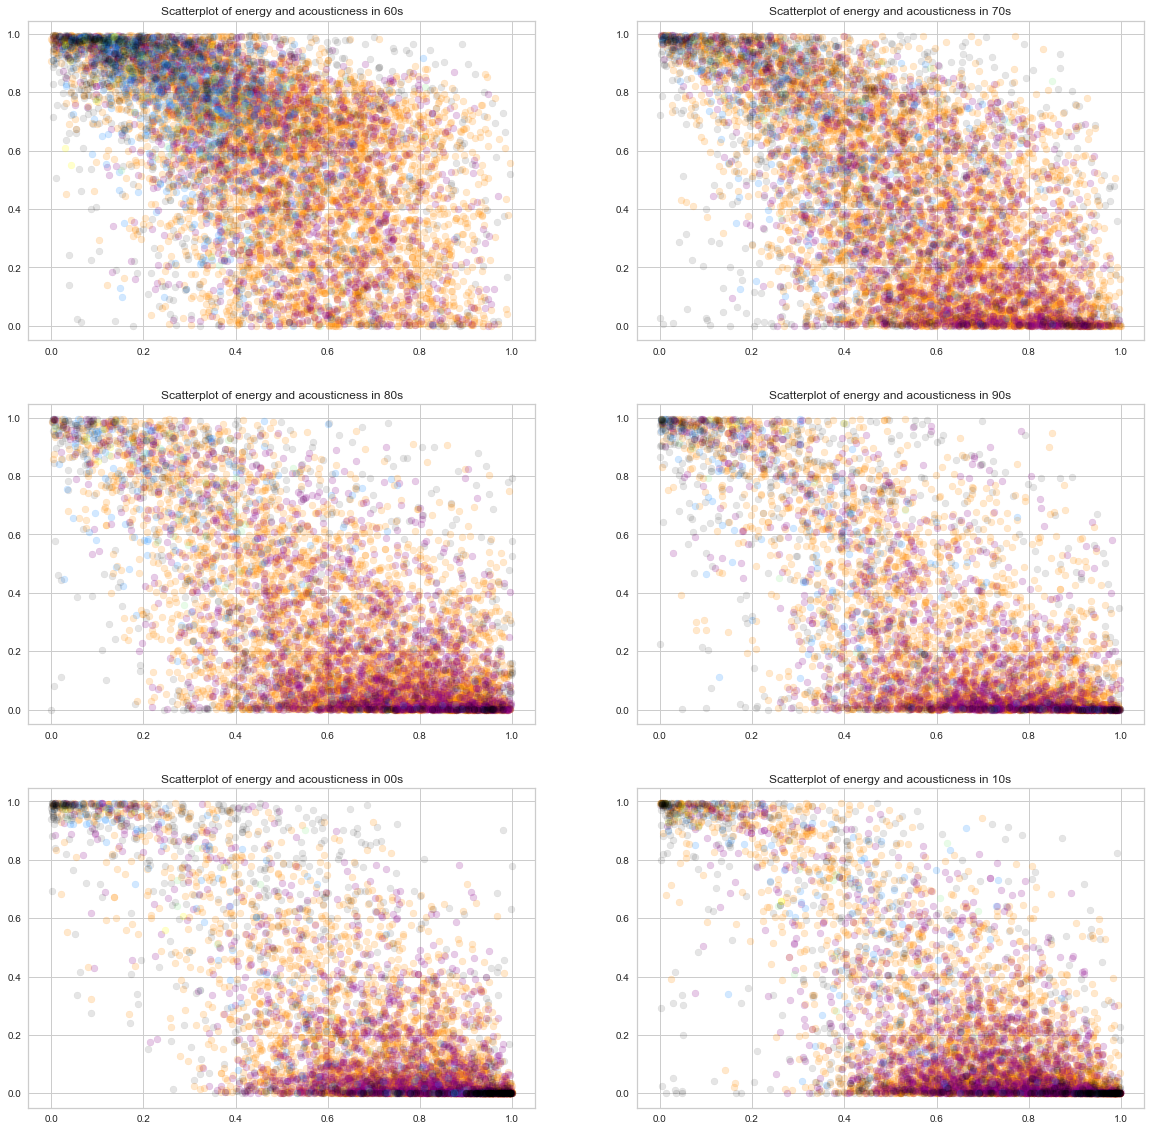

In [59]:
plt.figure(figsize=(20,20))
ax1= plt.subplot(3,2,1)
plt.title('Scatterplot of energy and acousticness in 60s')
plot_clusters(np.array(df_time[df_time.decade==1960]),dbscan_clusters[df_time.decade==1960],4,9,True)
plt.subplot(3,2,2, sharex= ax1, sharey=ax1)
plt.title('Scatterplot of energy and acousticness in 70s')
plot_clusters(np.array(df_time[df_time.decade==1970]),dbscan_clusters[df_time.decade==1970],4,9,True)
plt.subplot(3,2,3, sharex= ax1, sharey=ax1)
plt.title('Scatterplot of energy and acousticness in 80s')
plot_clusters(np.array(df_time[df_time.decade==1980]),dbscan_clusters[df_time.decade==1980],4,9,True)
plt.subplot(3,2,4, sharex= ax1, sharey=ax1)
plt.title('Scatterplot of energy and acousticness in 90s')
plot_clusters(np.array(df_time[df_time.decade==1990]),dbscan_clusters[df_time.decade==1990],4,9,True)
plt.subplot(3,2,5, sharex= ax1, sharey=ax1)
plt.title('Scatterplot of energy and acousticness in 00s')
plot_clusters(np.array(df_time[df_time.decade==2000]),dbscan_clusters[df_time.decade==2000],4,9,True)
plt.subplot(3,2,6, sharex= ax1, sharey=ax1)
plt.title('Scatterplot of energy and acousticness in 10s')
plot_clusters(np.array(df_time[df_time.decade==2010]),dbscan_clusters[df_time.decade==2010],4,9,True)

In this depiction the noise is also displayed. Most of it seems to be from the 60s and has extreme values of energy or acousticness. Also we see a covariance of these two dimensions. This covariance seem to change with the decades. In the 60s and 70s the correlation does not seem as strong as the correlation since the 90s. Since the 90s the corners are nearly empty and seem to drift into the extremes.

After analyzing, cleaning and transforming the data, we used two ways to cluster our songs in groups. The most promising clustering was the density based approach, where we divided our songs in a handful of groups, while not labeling too many songs as noise. With the calculated assignments to the groups we can use them in multiple ways:

- When a person listens to a song often or likes it, we can recommend songs of the same group. Because the songs are similar to the liked song, chances are high that the song fits the taste of the listener.
- Music producers could also use medoids or average values of certain groups to create songs which sound familiar to other songs, because familiar songs are often liked better.

## 7. Discussion

While the assignments of the songs in different groups should be good, what should the app recommend when a user listens to a song labeled as noise? To solve this an approach with a EM-Algorithm. If a song gets liked, which could be part of multiple groups with a certain probability, there could be recommendations out of multiple groups where the probability is high enough.

To further improve recommendations of songs user data of spotify users would help. Then you could analyze which songs are often listened to by the same person.

The author of this dataset states that half of the songs of this datasets are considered hits, because they are part of billboards and often heard playlists. The other half of the songs are songs which were not part of such playlists and billboards. I would assume that the hit songs are overrepresented in this dataset, because most of the songs are not hits which make it to billboards and playlists. With more flopped songs the clustering may have looked differently.

I could not find and verify the second API the author used "call for Audio Analysis", therefore it is hard to asses the quality of these features. 